In [1]:
import detect_heds_module_path
from holoeye import slmdisplaysdk
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import csv
import time
from pypylon import pylon
import cv2
import copy

shape is:  (1080, 1920)
dataWidth = 1920
dataHeight = 1080
[[3.14159265 3.14159265 3.14159265 ... 0.         3.14159265 0.        ]
 [0.         0.         0.         ... 3.14159265 3.14159265 3.14159265]
 [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 ...
 [3.14159265 3.14159265 0.         ... 0.         3.14159265 3.14159265]
 [3.14159265 0.         3.14159265 ... 3.14159265 0.         0.        ]
 [0.         0.         3.14159265 ... 3.14159265 3.14159265 0.        ]]
(1080, 1920)


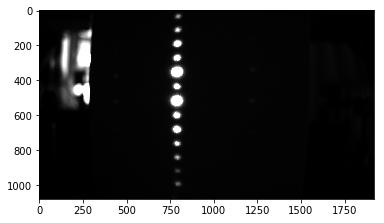

In [2]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()
#new_width = camera.Width.GetValue() - camera.Width.GetInc()
#if new_width >= camera.Width.GetMin():
#    camera.Width.SetValue(new_width)

# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
#showSLMPreview(slm, scale=0.0)


# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

size = (dataHeight,dataWidth)

# Calculate the data:
#data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
data = np.pi*(np.sign(np.random.normal(0,1,size)+1e-7) + 1)/2
print(data)
error = slm.showPhasevalues(data)


def cost(I_target, I_camera):
    return np.sum((abs(I_target-I_camera))**2)/np.size(I_target)

# Set this appropriately, can load the .npy file into this, and resize probably
TargetIntensity = np.load('target_intensity_05_10.npy')

print(TargetIntensity.shape)
plt.imshow(TargetIntensity, cmap='gray', vmin=0, vmax=255)
plt.show()

def flip(phasevalues, shape, d):
    y = copy.copy(phasevalues)
    a = np.random.randint(0,shape[0],d)
    b = np.random.randint(0,shape[1],d)
    #print(a,b)
    y[a, b] = np.pi-y[a, b]
    return y

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [128. 128. 128. ... 128. 128. 128.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]]
(1080, 1920)


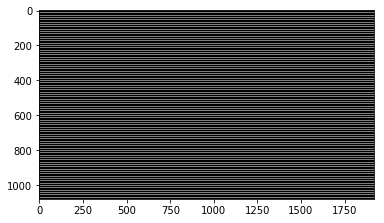

In [3]:
target_phase = np.loadtxt('target_phase_mask.dat.dat')
print(target_phase)
print(target_phase.shape)
plt.imshow(target_phase, cmap='gray', vmin=0, vmax=255)
plt.show()
target_phase = 2*np.pi*target_phase/255

In [5]:
numberOfImagesToGrab = 30

#data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
data_init = data
data_error = []
data_error.append(cost(data_init, target_phase))
intensity_error = []
count = 0
a = 0.5
TIME = []
COST = []
COST.append(99999999)

d = 2000

time_start = time.time()
Threshold = 1
while count < numberOfImagesToGrab and (COST[-1]>Threshold):
    TIME.append(time.time())
    data2 = flip(data, size, d)
    error = slm.showPhasevalues(data2)
    TIME.append(time.time())   
    
    camera.StartGrabbingMax(1)
    TIME.append(time.time())
    while camera.IsGrabbing():
        grabResult = camera.RetrieveResult(20000, pylon.TimeoutHandling_ThrowException)
        TIME.append(time.time())
        if grabResult.GrabSucceeded():
            TIME.append(time.time())
            # Access the image data.
            img = (np.asarray(grabResult.Array))**0.5 #.reshape((grabResult.Height, grabResult.Width))
            TIME.append(time.time())
        else:
            print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
        grabResult.Release()
            
    TIME.append(time.time())        
    img_sliced = img[4:1084, 64:1984]
    TIME.append(time.time())
    img_sliced[0:1080, 0:336]=0 # Removing background light
    TIME.append(time.time())
    I = img_sliced**2
    TIME.append(time.time())
    
    #cv2.imwrite('with_phase_06_10/with_phase'+ str(iter) + '.png', I)
    TIME.append(time.time())
    
    COST.append(cost(TargetIntensity, I))
    if COST[-1] < COST[-2]:
        data=data2
    else:
        data=data
        
    TIME.append(time.time())
    intensity_error.append(COST[-1])
    TIME.append(time.time())
    
    #img_fb = np.fft.fftshift(np.fft.ifft2(np.multiply(a*img_sliced+(1-a)*(TargetIntensity)**0.5, np.cos(data) + 1j*np.sin(data)))) # Multiplying phase mask to output electric field amplitude
    #TIME.append(time.time())
    #img_fb = np.fft.fftshift(np.fft.ifft2(a*img_sliced+(1-a)*(TargetIntensity)**0.5))
    #img_fb_phase = np.angle(img_fb)
    #data = np.angle(img_fb)%(2*np.pi)
    TIME.append(time.time())

    #data = img_fb_phase
    #data = data%(2*np.pi)
    
    data_error.append(cost(target_phase, data))
    TIME.append(time.time())
    count += 1
    TIME.append(time.time())
    

time_end = time.time()
print(data.shape)
print("TIME: ", time_end-time_start)
print("Converged in ", iter , " iterations")

i=1
while i in range(len(TIME)) and i != 0:
    print("Time taken for step ", i, " is ", TIME[i] - TIME[i-1], " seconds")
    i+=1

(1080, 1920)
TIME:  63.70564842224121
Converged in  <built-in function iter>  iterations
Time taken for step  1  is  0.36705493927001953  seconds
Time taken for step  2  is  0.21719765663146973  seconds
Time taken for step  3  is  0.08985543251037598  seconds
Time taken for step  4  is  0.0  seconds
Time taken for step  5  is  0.6202008724212646  seconds
Time taken for step  6  is  0.0  seconds
Time taken for step  7  is  0.0  seconds
Time taken for step  8  is  0.004994869232177734  seconds
Time taken for step  9  is  0.21238040924072266  seconds
Time taken for step  10  is  0.0  seconds
Time taken for step  11  is  0.45983171463012695  seconds
Time taken for step  12  is  0.0  seconds
Time taken for step  13  is  0.0  seconds
Time taken for step  14  is  0.28984594345092773  seconds
Time taken for step  15  is  0.0  seconds
Time taken for step  16  is  0.0  seconds
Time taken for step  17  is  0.3751544952392578  seconds
Time taken for step  18  is  0.18371009826660156  seconds
Time 

Time taken for step  167  is  0.010976791381835938  seconds
Time taken for step  168  is  0.0049974918365478516  seconds
Time taken for step  169  is  0.17005228996276855  seconds
Time taken for step  170  is  0.0  seconds
Time taken for step  171  is  0.46225643157958984  seconds
Time taken for step  172  is  0.0  seconds
Time taken for step  173  is  0.0  seconds
Time taken for step  174  is  0.34209680557250977  seconds
Time taken for step  175  is  0.0  seconds
Time taken for step  176  is  0.0  seconds
Time taken for step  177  is  0.45865345001220703  seconds
Time taken for step  178  is  0.13297772407531738  seconds
Time taken for step  179  is  0.06559920310974121  seconds
Time taken for step  180  is  0.0  seconds
Time taken for step  181  is  0.5632963180541992  seconds
Time taken for step  182  is  0.0009965896606445312  seconds
Time taken for step  183  is  0.0069925785064697266  seconds
Time taken for step  184  is  0.0019927024841308594  seconds
Time taken for step  185  

Time taken for step  388  is  0.0  seconds
Time taken for step  389  is  0.41002345085144043  seconds
Time taken for step  390  is  0.0010027885437011719  seconds
Time taken for step  391  is  0.014985084533691406  seconds
Time taken for step  392  is  0.005970478057861328  seconds
Time taken for step  393  is  0.14442133903503418  seconds
Time taken for step  394  is  0.0  seconds
Time taken for step  395  is  0.3145143985748291  seconds
Time taken for step  396  is  0.0  seconds
Time taken for step  397  is  0.0  seconds
Time taken for step  398  is  0.24801039695739746  seconds
Time taken for step  399  is  0.0  seconds
Time taken for step  400  is  0.0  seconds
Time taken for step  401  is  0.39025211334228516  seconds
Time taken for step  402  is  0.13401556015014648  seconds
Time taken for step  403  is  0.09285616874694824  seconds
Time taken for step  404  is  0.0  seconds
Time taken for step  405  is  0.4229602813720703  seconds
Time taken for step  406  is  0.0  seconds
Time 

In [6]:
camera.Close()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None


AssertionError: b'The SLM could not be initialized or was disconnected.'